## Cancerous/Noncancerous

In [1]:
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
import seaborn as sns

from eda import git_root

In [2]:
import re
from pathlib import Path
from joblib import Parallel, delayed


def _load_csv(path: Path) -> pd.DataFrame:
    """Load and add map."""
    tissue_id = int(re.findall(r"cluster_(.+?).csv", path.name)[0])
    df = pd.read_csv(path, index_col=0)
    df = df.assign(map=tissue_id + 1)
    return df

def load_csv(path_to_dir: Path, pattern: str):
    """Load files.

    Parameters
    ----------
    path_to_dir : Path
        path to parent directory
    pattern : str
        matching pattern of file name.
    
    Returns
    -------
    pd.DataFrame
        concatenated dataframe of all loaded files.
    """
    paths = sorted(list(path_to_dir.glob(pattern)))
    dfs = Parallel(n_jobs=8)(delayed(_load_csv)(path) for path in paths)

    # add length of each data to calculate weights for resampling
    for i, df in enumerate(dfs):
        df = df.assign(tissue_size=df.shape[0])
        dfs[i] = df

    return pd.concat(dfs).reset_index(drop=True)


ROOT = git_root(absolute=True)
INPUT_DIR_CLUSTER_FRACTION = ROOT / "data/submission/cluster_fraction/human/3_7/fraction.csv"
INPUT_DIR_SHANNON_BYSTATUS_MOUSE = ROOT / "data/submission/shannon_by_status/mouse/3_7"
INPUT_DIR_SHANNON_BYSTATUS_HUMAN = ROOT / "data/submission/shannon_by_status/human/3_7"


df_cluster_fraction = pd.read_csv(INPUT_DIR_CLUSTER_FRACTION, index_col=0)
with open("config/models/mouse.yaml", mode="r") as f:
    cfg_mouse = yaml.safe_load(f)
    df_shannon_mouse = load_csv(INPUT_DIR_SHANNON_BYSTATUS_MOUSE, "shannon*.csv")

with open("config/models/human.yaml", mode="r") as f:
    cfg_human = yaml.safe_load(f)
    df_shannon_human = load_csv(INPUT_DIR_SHANNON_BYSTATUS_HUMAN, "shannon*.csv")

In [3]:
df_cluster_fraction = pd.read_csv(INPUT_DIR_CLUSTER_FRACTION, index_col=0)
df_cluster_fraction = df_cluster_fraction.sort_values("fraction")
cluster_noncancerous = df_cluster_fraction["cluster"].iloc[:3].values
cluster_cancerous = df_cluster_fraction["cluster"].iloc[-3:].values

print(f"cluster Noncancerous: {cluster_noncancerous}")
print(f"cluster Cancerous: {cluster_cancerous}")

cluster Noncancerous: [23  1 20]
cluster Cancerous: [ 4 24 10]


In [4]:
# query
dfs = {}
condition_noncancerous = "cluster in @cluster_noncancerous"
condition_cancerous = "cluster in @cluster_cancerous"
for name, df in zip(["Mouse", "Human"], [df_shannon_mouse, df_shannon_human]):
    # query
    df_noncancerous = df.query(condition_noncancerous)
    df_cancerous = df.query(condition_cancerous)
    
    # add label
    df_noncancerous = df_noncancerous.assign(label="Noncancerous")
    df_cancerous = df_cancerous.assign(label="Cancerous")

    # add species
    df_noncancerous = df_noncancerous.assign(species=name)
    df_cancerous = df_cancerous.assign(species=name)

    dfs[f"{name} Noncancerous"] = df_noncancerous.reset_index(drop=True)
    dfs[f"{name} Cancerous"] = df_cancerous.reset_index(drop=True)

for name, _df in dfs.items():
    print(name, _df.shape)
    display(_df.head())

Mouse Noncancerous (10608844, 8)


,0,1,2,cluster,map,tissue_size,label,species
0,6.896755,6.426880,6.321167,1,1,16523080,Noncancerous,Mouse
1,6.871338,6.402214,6.281887,1,1,16523080,Noncancerous,Mouse
2,6.846374,6.387329,6.292725,1,1,16523080,Noncancerous,Mouse
3,6.839077,6.377571,6.266472,1,1,16523080,Noncancerous,Mouse
4,6.842407,6.458218,6.367615,1,1,16523080,Noncancerous,Mouse


Mouse Cancerous (6325272, 8)


,0,1,2,cluster,map,tissue_size,label,species
0,6.773621,6.710720,6.408848,4,1,16523080,Cancerous,Mouse
1,6.672275,6.706184,6.362053,4,1,16523080,Cancerous,Mouse
2,6.771572,6.706848,6.415913,4,1,16523080,Cancerous,Mouse
3,6.686070,6.714512,6.376457,4,1,16523080,Cancerous,Mouse
4,7.256435,7.234863,6.944492,4,1,16523080,Cancerous,Mouse


Human Noncancerous (298716, 8)


,0,1,2,cluster,map,tissue_size,label,species
0,6.929661,6.397434,6.339268,1,1,205600,Noncancerous,Human
1,7.008232,6.442497,6.439758,1,1,205600,Noncancerous,Human
2,6.946968,6.442619,6.372322,1,1,205600,Noncancerous,Human
3,7.030064,6.503025,6.500896,1,1,205600,Noncancerous,Human
4,6.955044,6.451870,6.389282,1,1,205600,Noncancerous,Human


Human Cancerous (7152844, 8)


,0,1,2,cluster,map,tissue_size,label,species
0,6.671536,6.539219,6.425579,4,1,205600,Cancerous,Human
1,6.697754,6.539280,6.440315,4,1,205600,Cancerous,Human
2,6.676540,6.499371,6.403694,4,1,205600,Cancerous,Human
3,6.694092,6.489494,6.411316,4,1,205600,Cancerous,Human
4,6.641724,6.461391,6.343697,4,1,205600,Cancerous,Human


In [5]:
from typing import Optional, Sequence
from numpy.typing import NDArray
import numpy as np


def downsample(df: pd.DataFrame, size: int,
               weights: Optional[NDArray[np.floating]] = None) -> pd.DataFrame:
    """Downsample dataframe

    Parameters
    ----------
    df : (N,) pd.DataFrame
    size : int
    weights : Optional[NDArray[np.floating]], optional
        weights for samples, by default None

    Returns
    -------
    (M,) pd.DataFrame
        downsampled dataframe, where M < N.
    """
    if weights is None:
        p = None
    else:
        p = weights / np.sum(weights)

    size = min(size, df.shape[0])
    inds = np.arange(df.shape[0])
    inds_selected = np.random.choice(inds, size, replace=False, p=p)
    return df.iloc[inds_selected]



# downsample
size = 100000
seed = 20220819
np.random.seed(seed)
for name, df in dfs.items():
    df = downsample(df, size, weights=1 / df["tissue_size"])
    dfs[name] = df.drop(["cluster", "tissue_size"], axis=1)
    print(name, dfs[name].shape)

Mouse Noncancerous (100000, 6)
Mouse Cancerous (100000, 6)
Human Noncancerous (100000, 6)
Human Cancerous (100000, 6)


,label,species,channel,value
0,Noncancerous,Mouse,0,7.282661
1,Noncancerous,Mouse,1,7.056004
2,Noncancerous,Mouse,2,7.053589
3,Noncancerous,Mouse,0,6.815395
4,Noncancerous,Mouse,1,6.660400


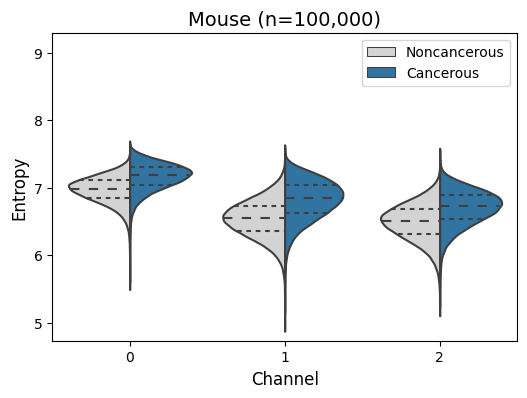

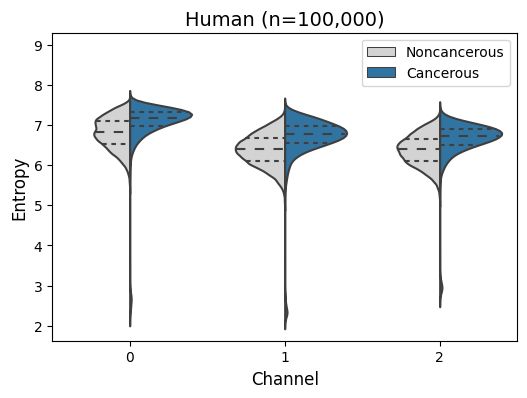

In [6]:
# plot entropy for all conditions.
_dfs = {k:v.drop("map", axis=1) for k, v in dfs.items()}
df_concat = pd.concat(_dfs, ignore_index=True)
df_concat = df_concat.set_index(["label", "species"])
df_concat = df_concat.stack().to_frame().reset_index()
df_concat = df_concat.rename({"level_2":"channel", 0:"value"}, axis=1)

display(df_concat.head())

for label in ["Mouse", "Human"]:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    _df = df_concat.query(f"species == '{label}'")
    sns.violinplot(data=_df, x="channel", y="value", hue="label", split=True,
                   inner="quart", lw=1,
                   palette={"Noncancerous": "lightgray",
                            "Cancerous": "tab:blue"},
                   ax=ax)
    ax.set_title(f"{label} (n={size:,})", fontsize=14)
    ax.set_ylim(None, 9.3)
    ax.legend(loc="best")
    ax.set_xlabel("Channel", fontsize=12)
    ax.set_ylabel("Entropy", fontsize=12)
    plt.show()

In [7]:
from scipy.stats import ttest_ind

# test paires
combs = [
    ('Mouse Noncancerous', 'Mouse Cancerous'),
    ('Human Noncancerous', 'Human Cancerous'),
]

results = []
channels = ["0", "1", "2"]
for null, alt in combs:
    for channel in channels:
        arr_null = dfs[null][channel].values
        arr_alt = dfs[alt][channel].values
        t_stat, p_val = ttest_ind(arr_null, arr_alt, equal_var=False)

        results.append(dict(null=null, alt=alt, channel=channel, t=t_stat,
                       p_val=p_val))

df_results = pd.DataFrame(results)
df_results.to_csv("ttest_species.csv")
display(df_results)

,null,alt,channel,t,p_val
0,Mouse Noncancerous,Mouse Cancerous,0,-215.998532,0.0
1,Mouse Noncancerous,Mouse Cancerous,1,-219.078732,0.0
2,Mouse Noncancerous,Mouse Cancerous,2,-174.028810,0.0
3,Human Noncancerous,Human Cancerous,0,-98.648373,0.0
4,Human Noncancerous,Human Cancerous,1,-115.654045,0.0
5,Human Noncancerous,Human Cancerous,2,-110.983069,0.0


## By stage

In [8]:
INPUT_PATH_TMA_META = ROOT / "data/submission/meta/human_tma_20220112.csv"

In [9]:
"""Functions to clean data."""
import re


def _clean_pT(x):
    m = re.match("(.+|^)(T[\d]|Tx)", x)
    if m:
        return m.group(2)
    return "Unknown"

def _clean_pN(x):
    m = re.match("(.+|^)(N[\d]|Nx)", x)
    if m:
        return m.group(2)
    return "Unknown"

def _clean_pM(x):
    m = re.match("(.+|^)(M[\d]|Mx)", x)
    if m:
        return m.group(2)
    return "Unknown"


def stage(T, N, M):
    """UICC 7th edition.
    Intrahepatic bile duct cancer.
    """
    Ts = ["T1", "T2", "T3", "T4"]
    Ns = ["N0", "N1"]
    
    if M == "M1":
        return "IV-B"
    elif N == "N1":
        return "IV-A"
    elif T == "T1":
        return "I"
    elif T == "T2":
        return "II"
    elif T == "T3":
        return "III"
    elif T == "T4":
        return "IV-A"
    return "Unknown"


def add_uicc_classification(df):
    """Add UICC classification to the dataframe."""
    df = (df.assign(T=df["pTNM"].apply(lambda x: _clean_pT(x)))
          .assign(N=df["pTNM"].apply(lambda x: _clean_pN(x)))
          .assign(M=df["pTNM"].apply(lambda x: _clean_pM(x))))
    # stages
    stages = [stage(*(df.iloc[i].loc["T":"M"]))
              for i in range(df.shape[0])]
    df = df.assign(stage=stages)
    return df

In [10]:
# load meta information
df_meta = pd.read_csv(INPUT_PATH_TMA_META, index_col=0)
df_meta["sex"].replace("F", "Female", inplace=True)
df_meta["sex"].replace("M", "Male", inplace=True)

# each patient has two images.
_df_meta_undrop = add_uicc_classification(df_meta)
_df_meta_undrop = _df_meta_undrop.ffill()

ustages, ucounts = np.unique(_df_meta_undrop["stage"], return_counts=True)
print('ustages:', ustages)
print('ucounts:', ucounts)
display(_df_meta_undrop.head())

ustages: ['I' 'II' 'III' 'IV-A' 'IV-B' 'Unknown']
ucounts: [22 24 10 16  6 12]


,map,TMA_ID,Unknown,age,sex,Organ,Diagnosis,pTNM,T,N,M,stage
0,1,09D13929,A4,69,Male,Liver,Intrahepatic cholangiocarcinoma,"pT1, pNx, pMx, R0",T1,Nx,Mx,I
1,2,09D13929,A4,69,Male,Liver,Intrahepatic cholangiocarcinoma,"pT1, pNx, pMx, R0",T1,Nx,Mx,I
2,3,09D15269,D5,64,Male,Liver,Intrahepatic cholangiocarcinoma,"T4, N1, Mx, R1",T4,N1,Mx,IV-A
3,4,09D15269,D5,64,Male,Liver,Intrahepatic cholangiocarcinoma,"T4, N1, Mx, R1",T4,N1,Mx,IV-A
4,5,09D16005,B1,70,Male,Liver,primary hepatic cholangiocarcinoma.,The tumour extends upto the capsule of the liv...,Unknown,Unknown,Unknown,Unknown


In [11]:
_df_meta = _df_meta_undrop[["map", "stage"]].astype("object")
df_merged = pd.merge(df_shannon_human, _df_meta, on="map", how="left")
print(df_merged.shape)
display(df_merged)

(19831248, 7)


,0,1,2,cluster,map,tissue_size,stage
0,6.929661,6.397434,6.339268,1,1,205600,I
1,7.008232,6.442497,6.439758,1,1,205600,I
2,6.946968,6.442619,6.372322,1,1,205600,I
3,7.030064,6.503025,6.500896,1,1,205600,I
4,6.955044,6.451870,6.389282,1,1,205600,I
...,...,...,...,...,...,...,...
19831243,6.530239,6.781033,6.455757,30,10,215360,IV-A
19831244,6.634216,6.855564,6.537075,30,10,215360,IV-A
19831245,6.691963,6.894566,6.604214,30,10,215360,IV-A
19831246,6.764587,6.964783,6.683681,30,10,215360,IV-A


In [12]:
# query
dfs_human = {}
condition_normal = "cluster in @cluster_noncancerous & stage != 'Unknown'"
condition_abnormal = "cluster in @cluster_cancerous & stage != 'Unknown'"

# query
df_normal = df_merged.query(condition_normal)
df_abnormal = df_merged.query(condition_abnormal)

# add label
df_normal = df_normal.assign(label="Noncancerous")
df_abnormal = df_abnormal.assign(label="Cancerous")

dfs_human["Noncancerous"] = df_normal.reset_index(drop=True)
dfs_human["Cancerous"] = df_abnormal.reset_index(drop=True)

for name, _df in dfs_human.items():
    print(name, _df.shape)
    display(_df.head())

Noncancerous (265544, 8)


,0,1,2,cluster,map,tissue_size,stage,label
0,6.929661,6.397434,6.339268,1,1,205600,I,Noncancerous
1,7.008232,6.442497,6.439758,1,1,205600,I,Noncancerous
2,6.946968,6.442619,6.372322,1,1,205600,I,Noncancerous
3,7.030064,6.503025,6.500896,1,1,205600,I,Noncancerous
4,6.955044,6.451870,6.389282,1,1,205600,I,Noncancerous


Cancerous (6167704, 8)


,0,1,2,cluster,map,tissue_size,stage,label
0,6.671536,6.539219,6.425579,4,1,205600,I,Cancerous
1,6.697754,6.539280,6.440315,4,1,205600,I,Cancerous
2,6.676540,6.499371,6.403694,4,1,205600,I,Cancerous
3,6.694092,6.489494,6.411316,4,1,205600,I,Cancerous
4,6.641724,6.461391,6.343697,4,1,205600,I,Cancerous


In [13]:
df_human_merged = pd.concat(dfs_human.values())
print("merged", df_human_merged.shape)
display(df_human_merged)

groups = df_human_merged.groupby(["stage"])
stage_size = groups.sum()["tissue_size"]
print(stage_size)

merged (6433248, 8)


,0,1,2,cluster,map,tissue_size,stage,label
0,6.929661,6.397434,6.339268,1,1,205600,I,Noncancerous
1,7.008232,6.442497,6.439758,1,1,205600,I,Noncancerous
2,6.946968,6.442619,6.372322,1,1,205600,I,Noncancerous
3,7.030064,6.503025,6.500896,1,1,205600,I,Noncancerous
4,6.955044,6.451870,6.389282,1,1,205600,I,Noncancerous
...,...,...,...,...,...,...,...,...
6167699,6.985229,6.866909,6.729099,24,10,215360,IV-A,Cancerous
6167700,7.031529,6.914761,6.771858,24,10,215360,IV-A,Cancerous
6167701,7.026882,6.924297,6.769009,24,10,215360,IV-A,Cancerous
6167702,7.013149,6.933743,6.770752,24,10,215360,IV-A,Cancerous


stage
I       402129503888
II      426101285456
III     197020341504
IV-A    298281273696
IV-B    137991979424
Name: tissue_size, dtype: int64


In [14]:
dfs_human_stage = {}
for name, df in groups:
    print(name, df.shape)
    df["stage_size"] = stage_size[name]
    dfs_human_stage[name] = df

# df_concat = pd.concat(dfs_human_stage)
# groups = df_concat.groupby(["label"])
# dfs = {}
# for name, df in groups:
#     print(name, df.shape)
#     dfs[name] = df

I (1746068, 8)
II (1890956, 8)
III (910248, 8)
IV-A (1296520, 8)
IV-B (589456, 8)


In [15]:
# downsample
size = 100000
seed = 20220819
np.random.seed(seed)
for name, df in dfs_human_stage.items():
    df = downsample(df, size, weights=1 / df["stage_size"])
    dfs[name] = df.drop(["cluster", "tissue_size"], axis=1)
    print(name, dfs[name].shape)

I (100000, 7)
II (100000, 7)
III (100000, 7)
IV-A (100000, 7)
IV-B (100000, 7)


,label,map,stage,channel,value
0,Noncancerous,1,NaN,0,7.282661
1,Noncancerous,1,NaN,1,7.056004
2,Noncancerous,1,NaN,2,7.053589
3,Noncancerous,5,NaN,0,6.815395
4,Noncancerous,5,NaN,1,6.660400


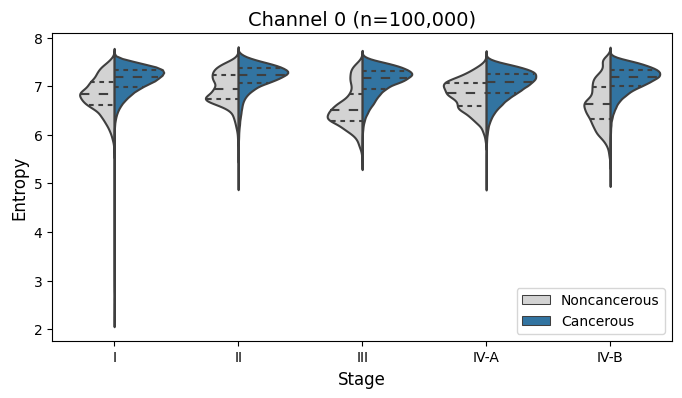

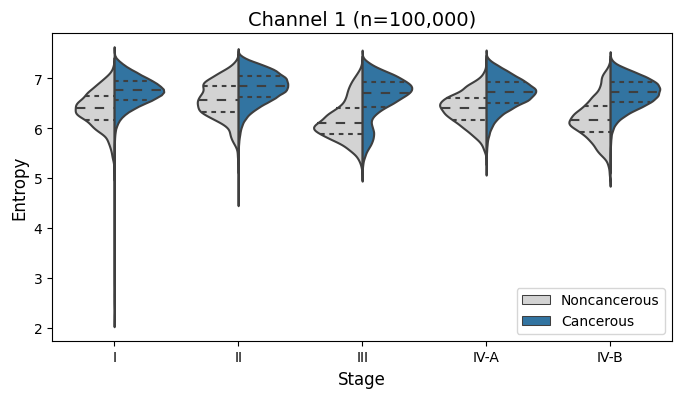

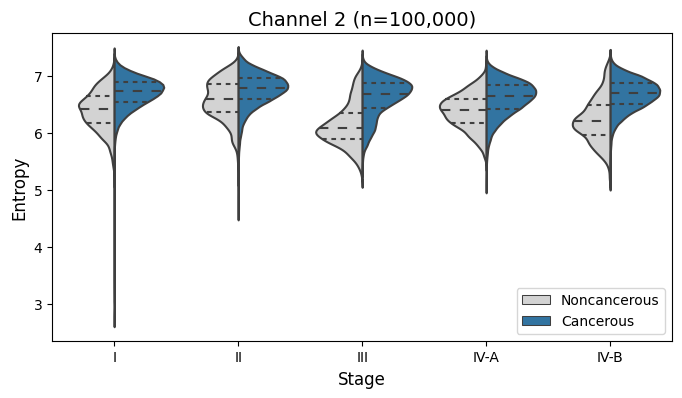

In [16]:
# plot entropy for all conditions.
df_concat = pd.concat(dfs, ignore_index=True)
df_concat = (df_concat
             .set_index(["label", "map", "stage"])
             .drop(["stage_size", "species"], axis=1))
df_concat = df_concat.stack().to_frame().reset_index()
df_concat = df_concat.rename({"level_3":"channel", 0:"value"}, axis=1)
display(df_concat.head())


# plot per stage
for channel in [0, 1, 2]:
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    _df = df_concat.query(f"channel == '{channel}'")
    sns.violinplot(data=_df, x="stage", y="value", hue="label", split=True,
                   inner="quart", lw=1,
                   palette={"Noncancerous": "lightgray",
                            "Cancerous": "tab:blue"},
                   order=["I", "II", "III", "IV-A", "IV-B"],
                   hue_order=["Noncancerous", "Cancerous"],
                   ax=ax)
    ax.set_title(f"Channel {channel} (n={size:,})", fontsize=14)
    ax.set_ylim(None, None)
    ax.legend(loc="lower right")
    ax.set_xlabel("Stage", fontsize=12)
    ax.set_ylabel("Entropy", fontsize=12)
    plt.show()

### JS divergenceの計算

In [17]:
import numpy as np
from numpy.typing import NDArray


def kl_divergence(p: NDArray[np.floating], q: NDArray[np.floating], nbins=10):
    """Calculate KL diversence.
    
    Parameters
    ----------
    p, q: pandas.Series
    nbins: int

    Returns
    -------
    KL divergence: float
    """
    vmin = min(p.min(), q.min())
    vmax = max(p.max(), q.max())

    bins = np.linspace(vmin, vmax, nbins + 1)
    p_hist, _ = np.histogram(p, bins=bins)
    q_hist, _ = np.histogram(q, bins=bins)
    
    #合計を1にするため、全合計でわる
    p_hist = p_hist / np.sum(p_hist)
    q_hist = q_hist / np.sum(q_hist)
    
    return np.sum([pi * np.log((pi + 1e-8) / (qi + 1e-8))
                   for pi, qi in zip(p_hist, q_hist)])


def js_divergence(p: NDArray[np.floating], q: NDArray[np.floating], nbins=10):
    """Calculate JS diversence.
    
    Parameters
    ----------
    p, q: pandas.Series
    nbins: int

    Returns
    -------
    JS divergence: float
    """
    kld1 = kl_divergence(p, q, nbins)
    kld2 = kl_divergence(q, p, nbins)
    return 0.5 * (kld1 + kld2)

In [18]:
# calculate JS divergence per stage

nbins = 128
stages=["I", "II", "III", "IV-A", "IV-B"]
results = []
for channel in [0, 1, 2]:
    _df = df_concat.query(f"channel == '{channel}'")
    for stage in stages:
        _df_normal = _df.query(f"label == 'Noncancerous' & stage == '{stage}'")
        _df_abnormal = _df.query(f"label == 'Cancerous' & stage == '{stage}'")
        jsd = js_divergence(_df_normal["value"].values,
                            _df_abnormal["value"].values, nbins)
        results.append(dict(
            channel=channel,
            stage=stage,
            jsd=jsd,
        ))

df_jsd = pd.DataFrame(results)
display(df_jsd)

,channel,stage,jsd
0,0,I,0.553989
1,0,II,0.383888
2,0,III,1.113153
3,0,IV-A,0.274455
4,0,IV-B,1.050656
5,1,I,0.759151
6,1,II,0.363231
7,1,III,0.741078
8,1,IV-A,0.747524
9,1,IV-B,1.216192


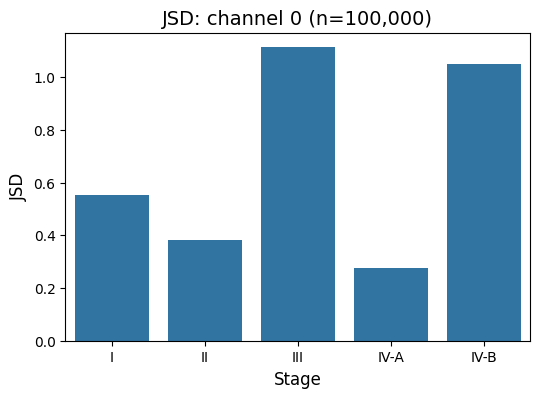

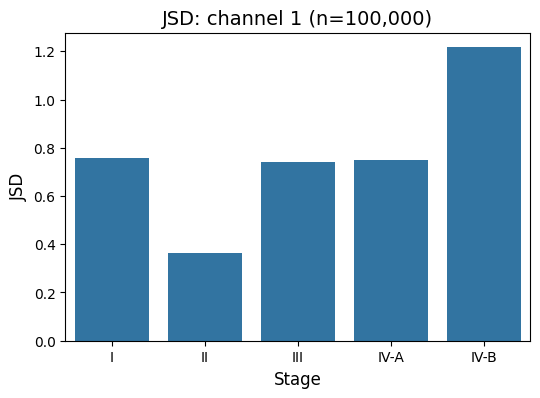

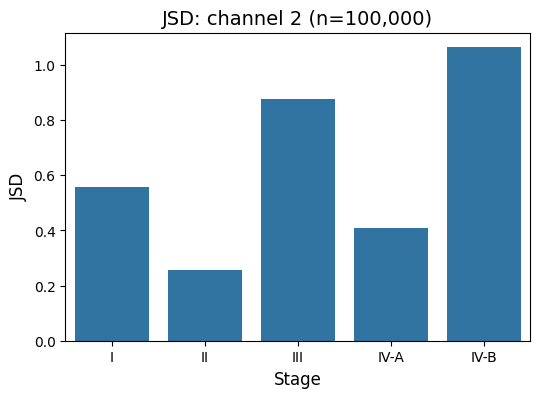

In [19]:
# plot JS per stages
for channel in [0, 1, 2]:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    _df = df_jsd.query(f"channel == {channel}")
    sns.barplot(data=_df, x="stage", y="jsd", 
                order=["I", "II", "III", "IV-A", "IV-B"],
                ax=ax, color="tab:blue")
    ax.set_title(f"JSD: channel {channel} (n={size:,})", fontsize=14)
    ax.set_xlabel("Stage", fontsize=12)
    ax.set_ylabel("JSD", fontsize=12)
    plt.show()